# Assignment 3: Solving Traveling Salesman Problem using Simulated Annealing

## Imports

In [20]:
import random
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time


## Basic Parts

### Basic functions(class Temperature,calculate_total_distance,simulated_annealing)

In [3]:
class Temperature:
    def __init__(self, f, parameters):
        self.updatefunction = f
        self.parameters = parameters    # Parameters for the cooling function
        self.current_temp = parameters["initial_temp"]
        self.iter = 1  #Initialize iteration counter

    def update_temperature(self):
        """Method to update temperature"""
        self.current_temp = self.updatefunction(self.current_temp, self.iter, self.parameters)
        self.iter += 1


def calculate_total_distance(cities, route):
    """Calculate the total distance for a given route"""
    total_distance = 0
    number_of_cities = len(cities)

    for i in range(number_of_cities):
        # Calculate the distance between adjacent cities
        city1 = cities[route[i % number_of_cities]]
        city2 = cities[route[(i + 1) % number_of_cities]]
        distance = math.sqrt((city1[0] - city2[0])**2 + (city1[1] - city2[1])**2)
        total_distance += distance
        
    return total_distance

def simulated_annealing(cities, Optimize_function, Cooling_fuction, parameters):
    """Simulated annealing algorithm main function"""

    # Randomly initialize a solution (route)
    current_route = list(range(len(cities)))
    random.shuffle(current_route)

    current_distance = calculate_total_distance(cities, current_route)
    temper = Temperature(Cooling_fuction, parameters)
    distance_iter = []
    temper_iter = []
    while temper.iter < parameters["max_iter"]:
        for _ in range(parameters["markov_chain_length"]):
            # Generate new solution
            
            new_route = Optimize_function(current_route)
            new_distance = calculate_total_distance(cities, new_route)

            # Determine whether to accept the new solution
            if new_distance < current_distance or random.random() < math.exp((current_distance - new_distance) / temper.current_temp):
            #if new_distance < current_distance:
                current_route = new_route
                current_distance = new_distance
        distance_iter.append((temper.iter,current_distance))     
        temper_iter.append((temper.iter,temper.current_temp))    
        temper.update_temperature()

    #print(temper.iter)
    #print(temper.current_temp)
    return current_route, current_distance, distance_iter, temper_iter

### Cooling functions

In [5]:
def Geometric_cooling(current_temp, iter, parameters):
    return current_temp * parameters["cooling_rate"]

def Linear_cooling(current_temp, iter, parameters):
    return current_temp - parameters["initial_temp"] / parameters["max_iter"]

# This function is found online and we did some change about making one number into 'a'
def Logarithmic_cooling(current_temp, iter, parameters):
    return parameters["initial_temp"] / ( 1 + parameters["a"] * np.log(1 + iter))

def Basic_cooling(current_temp, iter, parameters):
    return parameters["a"] / np.log(iter + parameters["b"])

### Optimizing route functions
We choose 2opt for this assignment.

In [6]:
def two_opt_swap(route):
    """Applies 2-opt swapping on the given route between cities i and k"""
    i, k = sorted(random.sample(range(1, len(route)), 2))
    new_route = route[0:i]
    new_route.extend(reversed(route[i:k + 1]))
    new_route.extend(route[k + 1:])
    return new_route

def move_node(route):
    """
    Move a city to a new position in the route.

    :param route: List of cities representing the current route.
    :param node_index: Index of the city to be moved.
    :param new_position: New position where the city will be moved.
    :return: New route with the city moved to the new position.
    """
    i, k = random.sample(range(1, len(route)), 2)
    city = route.pop(i)  # Remove the city from its current position
    route.insert(k, city)  # Insert the city at the new position
    return route

def three_opt_swap(route):
    """Apply 3-opt swapping to find a shorter route."""
    # Ensure i, j, k are in ascending order
    i, j, k = sorted(random.sample(range(1, len(route)), 3))
    new_route = route[:]
    # Choose a random 3-opt move
    n = random.random()
    if n < 0.25:
        # Reverse segment between i and j
        new_route[i:j] = reversed(new_route[i:j])
    elif n < 0.5:
        # Reverse segment between j and k
        new_route[j:k] = reversed(new_route[j:k])
    elif n < 0.75:
        # Reverse segment between i and k
        new_route[i:k] = reversed(new_route[i:k])
    else:
        # 3-opt move: Reorder segments
        new_route = new_route[:i] + new_route[j:k] + new_route[i:j] + new_route[k:]
    return new_route



### Read_test_tsp_file

In [7]:
# First, read the uploaded file eil51.tsp.txt
file_path = 'plots/eil51.tsp.txt'

# Define a function to read TSP files and parse city coordinates
def read_tsp_file(file_path):
    cities = []
    with open(file_path, 'r') as file:
        for line in file:
            parts = line.split()
            if len(parts) == 3 and parts[0].isdigit():
                cities.append((float(parts[1]), float(parts[2])))
    return cities

# Call the function and read the city coordinates
cities = read_tsp_file(file_path)

### Run test

In [8]:
initial_temp = 20
cooling_rate = 0.995
max_iter = 1000
markov_chain_length = 1000
parameters_Geometric_cooling = {"cooling_method_name" : "Geometric_cooling",
                                "initial_temp" : initial_temp, 
                                "max_iter": max_iter,
                                "markov_chain_length":markov_chain_length, 
                                "cooling_rate": cooling_rate}

parameters_Linear_cooling = {"cooling_method_name" : "Linear_cooling",
                                "initial_temp" : initial_temp, 
                                "max_iter": max_iter,
                                "markov_chain_length":markov_chain_length, 
                                "cooling_rate": cooling_rate}

parameters_Logarithmic_cooling = {"cooling_method_name" : "Logarithmic_cooling",
                                "initial_temp" : initial_temp, 
                                "max_iter": max_iter,
                                "markov_chain_length":markov_chain_length, 
                                "a" : initial_temp, 
                                "cooling_rate": cooling_rate}

parameters_Basic_cooling = {"cooling_method_name" : "Basic_cooling",
                            "initial_temp" : initial_temp, 
                            "max_iter": max_iter,
                            "markov_chain_length":markov_chain_length, 
                            "a" : initial_temp, 
                            "b" : 5}

cooling_functions = [
    (Geometric_cooling, parameters_Geometric_cooling),
    #(Basic_cooling, parameters_Basic_cooling),
    (Linear_cooling, parameters_Linear_cooling),
    (Logarithmic_cooling, parameters_Logarithmic_cooling)
]

optimal_routes = []
optimal_distances = []
cooling_method_names = []
distance_iters = []
temper_iters = []

for cooling_function, parameters in cooling_functions:
    optimal_route, optimal_distance, distance_iter, temper_iter = simulated_annealing(cities, two_opt_swap, cooling_function, parameters)
    optimal_routes.append(optimal_route)
    optimal_distances.append(optimal_distance)
    cooling_method_names.append(parameters["cooling_method_name"])
    distance_iters.append(distance_iter)
    temper_iters.append(temper_iter)
    print("Optimal Route:", optimal_route)
    print("Optimal Distance:", optimal_distance)
    print()

Optimal Route: [18, 41, 43, 14, 44, 32, 38, 9, 48, 37, 4, 36, 16, 3, 17, 46, 11, 45, 50, 5, 26, 0, 21, 31, 10, 1, 15, 49, 8, 29, 33, 20, 28, 19, 34, 35, 2, 27, 30, 25, 7, 47, 22, 6, 42, 23, 13, 24, 12, 40, 39]
Optimal Distance: 435.28684508048707

Optimal Route: [11, 46, 17, 3, 16, 36, 4, 37, 10, 15, 1, 21, 7, 25, 30, 27, 2, 35, 34, 19, 28, 20, 49, 33, 29, 8, 48, 9, 38, 32, 44, 14, 43, 41, 39, 18, 40, 12, 24, 13, 23, 42, 6, 22, 47, 5, 26, 0, 31, 50, 45]
Optimal Distance: 436.80194294992094

Optimal Route: [29, 38, 9, 48, 4, 37, 8, 49, 15, 10, 1, 21, 31, 50, 45, 11, 46, 3, 16, 36, 14, 32, 44, 43, 41, 18, 39, 40, 12, 17, 24, 13, 5, 23, 42, 22, 6, 25, 47, 26, 0, 7, 30, 27, 2, 35, 34, 19, 28, 20, 33]
Optimal Distance: 463.1933993528265



### Visualization part

In [10]:
def plot_tsp_solution(cities, route, cooling_method_name):
    """Drawing a solution to the traveling salesman problem"""
    plt.figure(figsize=(10, 6))

    # Extract and draw city coordinates
    x = [city[0] for city in cities]
    y = [city[1] for city in cities]
    plt.scatter(x, y, color='blue')

    #Add city label
    for i, city in enumerate(cities):
        plt.text(city[0], city[1], str(i), fontsize=9, ha='right', va='bottom')

    # Draw path
    for i in range(len(route)):
        start_city = cities[route[i]]
        end_city = cities[route[(i + 1) % len(route)]]
        plt.plot([start_city[0], end_city[0]], [start_city[1], end_city[1]], color='red')

    plt.title(f'TSP Solution, {cooling_method_name}')
    plt.xlabel('X Coordinate')
    plt.ylabel('Y Coordinate')
    plt.grid(True)
    plt.show()

def cooling_function_compare(cooling_method_names, parameter_iters, parameter_name):
    """
    Function to compare different cooling methods for simulated annealing.
    
    Parameters:
    cooling_method_names (list): A list of names of the cooling methods.
    distance_iters (list): A list of tuples/lists containing iteration-distance pairs for each cooling method.
    """
    plt.figure(figsize=(10, 6))
    
    # Iterate over the provided cooling methods and distance-iteration data
    for method_name, dist_iter in zip(cooling_method_names, parameter_iters):
        # Unpack the iteration and distance data
        iters, distances = zip(*dist_iter)
        
        # Plot the data with a label for the legend
        plt.plot(iters, distances, label=method_name)
    
    # Add title and labels
    plt.title('Cooling Function Comparison')
    plt.xlabel('K (iterations)')
    plt.ylabel(f'{parameter_name}')
    plt.legend(title='Cooling Schedules')
    plt.grid(True)
    
    # Display the plot
    plt.show()

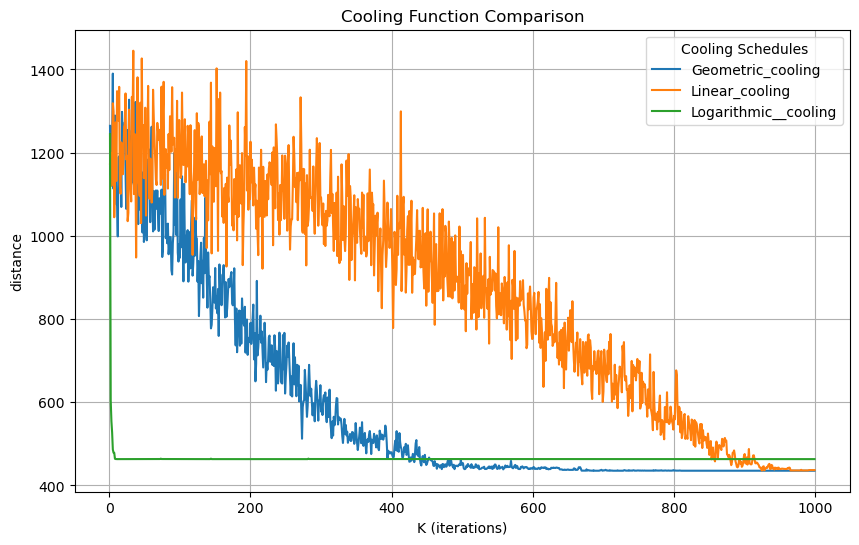

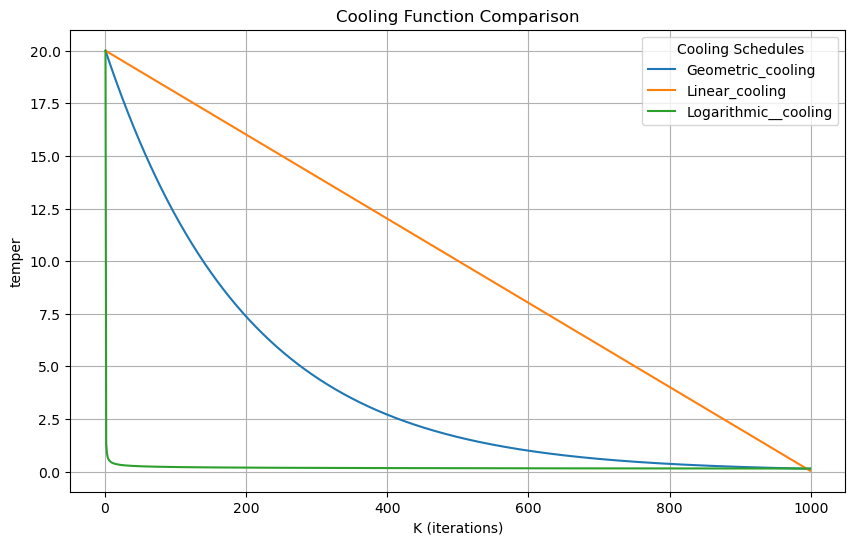

In [11]:
cooling_function_compare(cooling_method_names, distance_iters, "distance")
cooling_function_compare(cooling_method_names, temper_iters, "temper")

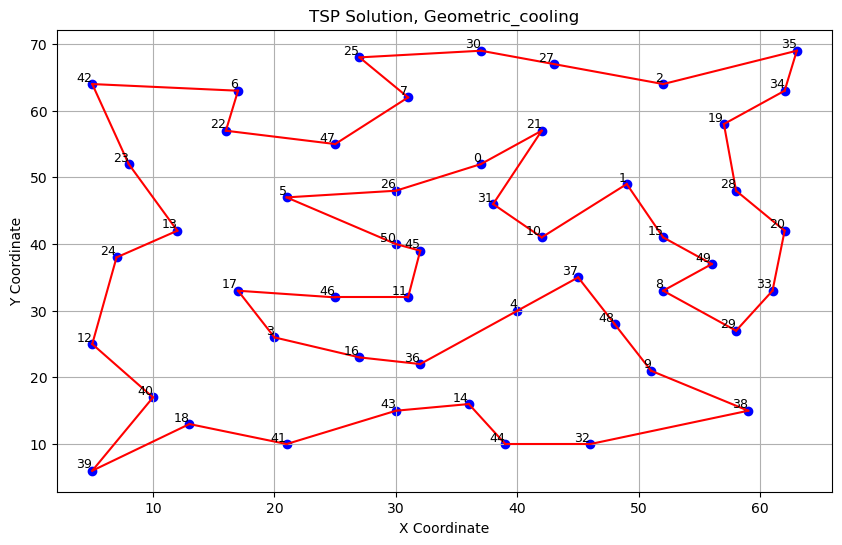

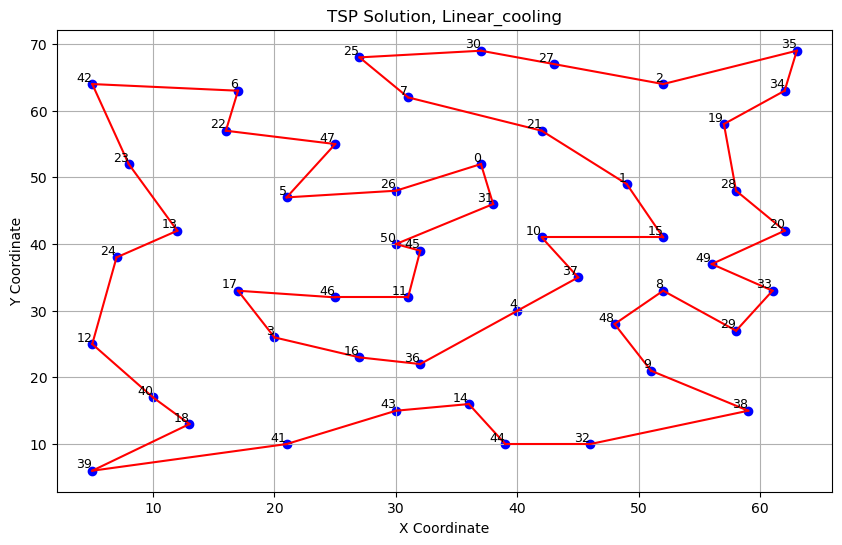

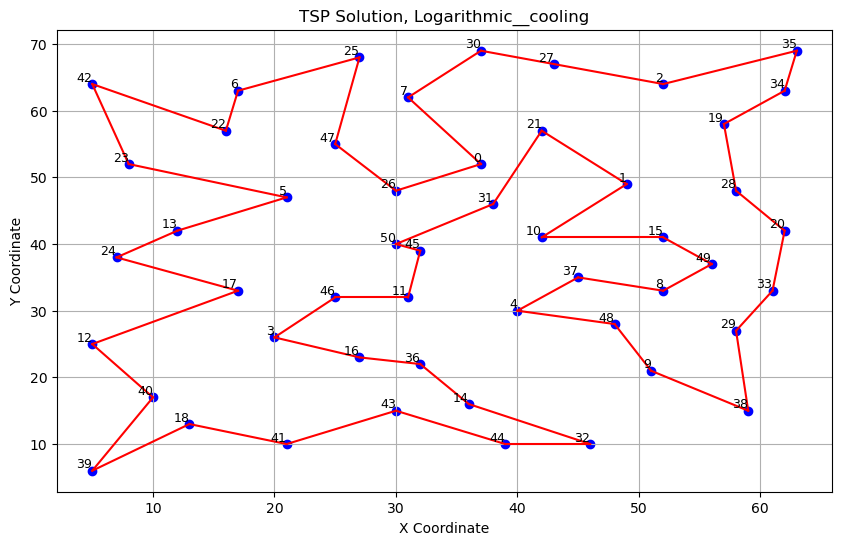

In [12]:
# Draw the solution using the optimal path and city coordinates found previously
for optimal_route, cooling_method_name in zip(optimal_routes, cooling_method_names):
    plot_tsp_solution(cities, optimal_route, cooling_method_name)

## Pre experiment

### Read_tsp_file

In [14]:
# First, read the uploaded file a280.tsp.txt
file_path = 'plots/a280.tsp.txt'

# Define a function to read TSP files and parse city coordinates
def read_tsp_file(file_path):
    cities = []
    with open(file_path, 'r') as file:
        for line in file:
            parts = line.split()
            if len(parts) == 3 and parts[0].isdigit():
                cities.append((float(parts[1]), float(parts[2])))
    return cities

# Call the function and read the city coordinates
cities = read_tsp_file(file_path)

### Initial test

In [15]:
initial_temp = 10
max_iter = 10000
markov_chain_length = 20

parameters_Linear_cooling = {"cooling_method_name" : "Linear_cooling",
                                "initial_temp" : initial_temp, 
                                "max_iter": max_iter,
                                "markov_chain_length":markov_chain_length, 
                                "cooling_rate": cooling_rate}

cooling_functions = [
    (Linear_cooling, parameters_Linear_cooling)    
]

optimal_routes = []
optimal_distances = []
cooling_method_names = []
distance_iters = []
temper_iters = []

for cooling_function, parameters in cooling_functions:
    optimal_route, optimal_distance, distance_iter, temper_iter = simulated_annealing(cities, two_opt_swap, cooling_function, parameters)
    optimal_routes.append(optimal_route)
    optimal_distances.append(optimal_distance)
    cooling_method_names.append(parameters["cooling_method_name"])
    distance_iters.append(distance_iter)
    temper_iters.append(temper_iter)

    print("Cooling_method_name:", parameters["cooling_method_name"])
    print("Optimal Route:", optimal_route)
    print("Optimal Distance:", optimal_distance)
    print()

Cooling_method_name: Linear_cooling
Optimal Route: [122, 121, 120, 42, 41, 40, 39, 38, 37, 34, 33, 35, 36, 49, 50, 51, 48, 47, 52, 53, 46, 45, 54, 55, 56, 58, 57, 43, 44, 59, 60, 62, 61, 117, 116, 114, 115, 85, 86, 83, 84, 64, 63, 65, 67, 68, 69, 66, 70, 71, 72, 73, 74, 76, 77, 75, 78, 79, 93, 94, 95, 96, 97, 92, 91, 90, 102, 103, 104, 105, 107, 108, 89, 80, 88, 81, 82, 87, 112, 111, 109, 110, 113, 106, 173, 172, 170, 171, 169, 168, 101, 100, 98, 99, 167, 166, 165, 164, 187, 188, 189, 185, 190, 192, 191, 193, 194, 195, 201, 202, 199, 196, 197, 198, 200, 143, 144, 145, 142, 141, 146, 140, 139, 138, 147, 148, 149, 177, 176, 175, 178, 179, 180, 181, 182, 183, 184, 186, 163, 162, 161, 160, 174, 159, 158, 157, 156, 118, 119, 150, 151, 155, 152, 154, 153, 129, 128, 127, 20, 130, 19, 18, 131, 132, 17, 16, 269, 133, 134, 268, 135, 267, 265, 137, 136, 266, 264, 263, 257, 258, 259, 260, 261, 262, 15, 270, 271, 272, 273, 274, 275, 276, 277, 278, 247, 246, 244, 237, 236, 235, 234, 232, 233, 227, 2

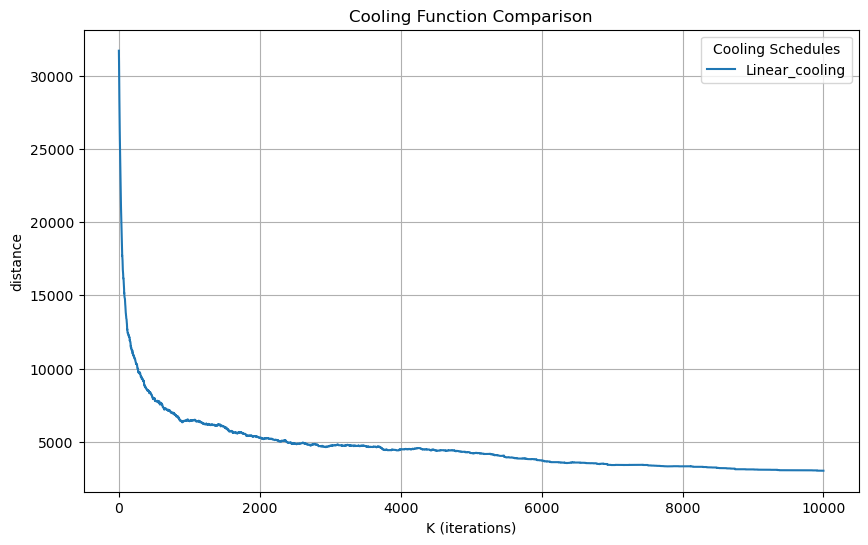

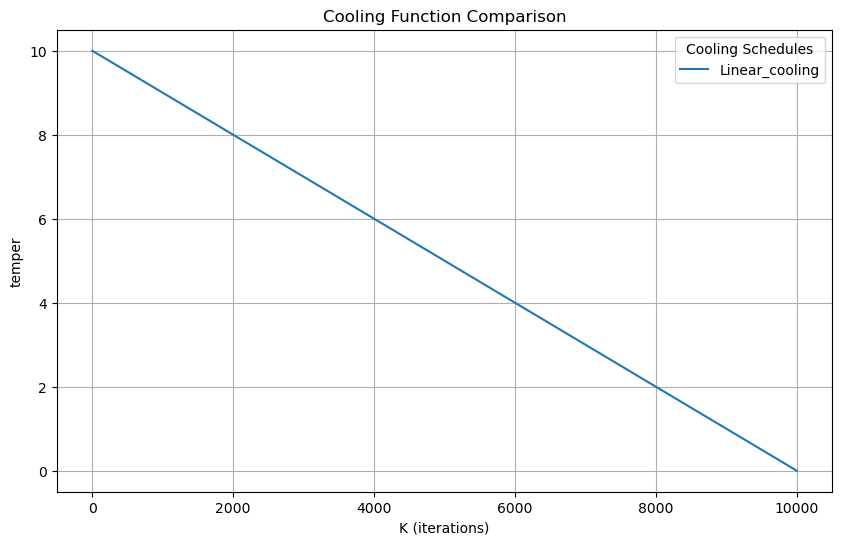

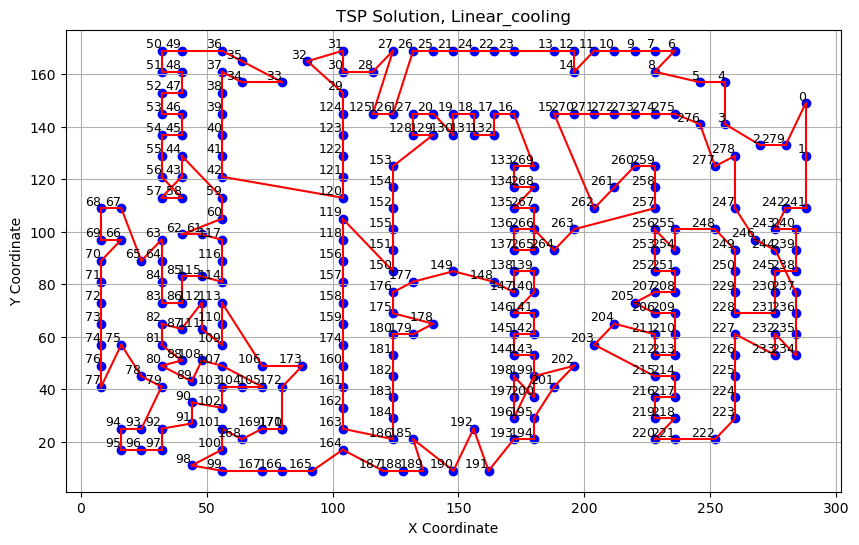

In [16]:
cooling_function_compare(cooling_method_names, distance_iters, "distance")
cooling_function_compare(cooling_method_names, temper_iters, "temper")

# Draw the solution using the optimal path and city coordinates found previously
for optimal_route, cooling_method_name in zip(optimal_routes, cooling_method_names):
    plot_tsp_solution(cities, optimal_route, cooling_method_name)

### Prove that a local minimum is obtained

In [17]:
best_route = optimal_route

In [19]:
def two_opt_best_swap(cities, route):
    """Finds the best 2-opt swap by trying all possible swaps."""
    best_distance = calculate_total_distance(cities, route)
    best_route = route[:]
    for i in range(1, len(route) - 1):
        for k in range(i + 1, len(route)):
            # Create new route with the swap between i and k
            new_route = route[:i] + route[i:k][::-1] + route[k:]
            new_distance = calculate_total_distance(cities, new_route)
            if new_distance < best_distance:
                best_distance = new_distance
                best_route = new_route
    return best_route

current_distance = calculate_total_distance(cities, best_route)
print(current_distance)
route = two_opt_best_swap(cities, best_route)
optimized_distance = calculate_total_distance(cities, route)
if current_distance == optimized_distance:
    print("It is a local min")
else:
    print("It is not a local min")

3021.4101738700138
It is not a local min


### Compare optimizing route functions using Linear_cooling

In [25]:
initial_temp = 10
max_iter = 10000
markov_chain_length = 100

parameters_Linear_cooling = {"cooling_method_name" : "Linear_cooling",
                                "initial_temp" : initial_temp, 
                                "max_iter": max_iter,
                                "markov_chain_length":markov_chain_length
                                }

cooling_functions = [
    (Linear_cooling, parameters_Linear_cooling)    
]

Optimizing_functions = [move_node, two_opt_swap, three_opt_swap]
Optimize_method_names = ["move_node", "two_opt_swap", "three_opt_swap"]

optimal_routes = []
optimal_distances = []
cooling_method_names = []
Optimizing_functions_names = []
distance_iters = []
temper_iters = []

for Optimizing_function,Optimize_method_name in zip(Optimizing_functions,Optimize_method_names):
    for cooling_function, parameters in cooling_functions:

        start_time = time.time()

        optimal_route, optimal_distance, distance_iter, temper_iter = simulated_annealing(cities, Optimizing_function, cooling_function, parameters)
        optimal_routes.append(optimal_route)
        optimal_distances.append(optimal_distance)
        cooling_method_names.append(parameters["cooling_method_name"])
        Optimizing_functions_names.append(Optimizing_function.__name__)
        distance_iters.append(distance_iter)
        temper_iters.append(temper_iter)

        end_time = time.time()
        elapsed_time = end_time - start_time
        print(f"Code running time: {elapsed_time} seconds")

        print("Optimize_method_name:", Optimize_method_name)
        print("Cooling_method_name:", parameters["cooling_method_name"])
        print("Optimal Route:", optimal_route)
        print("Optimal Distance:", optimal_distance)
        print()

Code running time: 145.49201273918152 seconds
Optimize_method_name: move_node
Cooling_method_name: Linear_cooling
Optimal Route: [145, 205, 248, 214, 34, 106, 73, 45, 153, 114, 194, 78, 25, 278, 197, 89, 221, 42, 140, 144, 191, 87, 147, 84, 210, 154, 28, 123, 79, 277, 58, 83, 122, 244, 64, 254, 184, 74, 57, 212, 213, 162, 69, 105, 75, 243, 143, 192, 202, 176, 125, 264, 211, 116, 228, 204, 110, 27, 41, 131, 159, 76, 43, 266, 135, 67, 158, 101, 164, 230, 128, 195, 272, 3, 261, 268, 19, 91, 33, 182, 233, 245, 149, 201, 16, 13, 92, 189, 166, 203, 157, 8, 274, 9, 242, 174, 179, 5, 188, 273, 207, 234, 2, 63, 219, 126, 66, 276, 256, 165, 257, 115, 187, 218, 163, 222, 98, 112, 102, 97, 239, 4, 60, 48, 81, 142, 77, 20, 226, 247, 267, 231, 70, 198, 137, 21, 55, 146, 38, 59, 269, 15, 108, 138, 173, 121, 237, 56, 6, 124, 133, 104, 223, 99, 251, 95, 26, 30, 249, 17, 238, 40, 148, 170, 44, 193, 151, 172, 12, 120, 227, 86, 107, 7, 139, 32, 130, 275, 46, 175, 156, 209, 200, 167, 220, 232, 235, 177, 11

### Visualization part to compare Optimizing route function

In [29]:
def plot_tsp_solution_compare_Optimizing_function(cities, route, cooling_method_name, Optimizing_functions_name):
    """Drawing a solution to the traveling salesman problem"""
    plt.figure(figsize=(10, 6))

    # Extract and draw city coordinates
    x = [city[0] for city in cities]
    y = [city[1] for city in cities]
    plt.scatter(x, y, color='blue')

    #Add city label
    for i, city in enumerate(cities):
        plt.text(city[0], city[1], str(i), fontsize=9, ha='right', va='bottom')

    # Draw path
    for i in range(len(route)):
        start_city = cities[route[i]]
        end_city = cities[route[(i + 1) % len(route)]]
        plt.plot([start_city[0], end_city[0]], [start_city[1], end_city[1]], color='red')

    plt.title(f'TSP Solution, {Optimizing_functions_name}',fontsize = 16)
    plt.xlabel('X Coordinate',fontsize = 14)
    plt.ylabel('Y Coordinate',fontsize = 14)
    plt.grid(True)
    plt.show()

def compare_Optimizing_function(cooling_method_names, Optimizing_functions_names, 
                             parameter_iters, parameter_name):
    """
    Function to compare different cooling methods for simulated annealing.
    
    Parameters:
    cooling_method_names (list): A list of names of the cooling methods.
    distance_iters (list): A list of tuples/lists containing iteration-distance pairs for each cooling method.
    """
    plt.figure(figsize=(10, 6))
    
    # Iterate over the provided cooling methods and distance-iteration data
    for cooling_method_name, Optimizing_functions_name, dist_iter in zip(cooling_method_names, Optimizing_functions_names, 
                                              parameter_iters):
        # Unpack the iteration and distance data
        iters, distances = zip(*dist_iter)
        
        # Plot the data with a label for the legend
        plt.plot(iters, distances, label=Optimizing_functions_name)
    
    # Add title and labels
    plt.title('Optimizing Functions Comparison',fontsize = 16)
    plt.xlabel('K (Iterations)',fontsize = 14)
    plt.ylabel(f'{parameter_name}',fontsize = 14)
    plt.legend(title='Optimizing Functions',fontsize = 14)
    plt.grid(True)
    
    # Display the plot
    plt.show()

In [ ]:
compare_Optimizing_function(cooling_method_names, Optimizing_functions_names, distance_iters, "Distance")
compare_Optimizing_function(cooling_method_names, Optimizing_functions_names, temper_iters, "Temper")
# Draw the solution using the optimal path and city coordinates found previously
Optimizing_functions_names = ["Move node", "Two opt swap", "Three opt swap"]
for optimal_route, cooling_method_name, Optimizing_functions_name in zip(optimal_routes, cooling_method_names, Optimizing_functions_names):
    plot_tsp_solution_compare_Optimizing_function(cities, optimal_route, cooling_method_name, Optimizing_functions_name)

### Draw box plox to compare two_opt_swap, three_opt_swap

In [ ]:
Optimizing_functions = [two_opt_swap, three_opt_swap]
boxs = []
n = 10

initial_temp = 10
max_iter = 1000
markov_chain_length = 200

parameters_Linear_cooling = {"cooling_method_name" : "Linear_cooling",
                                "initial_temp" : initial_temp, 
                                "max_iter": max_iter,
                                "markov_chain_length":markov_chain_length
                                }

optimal_routes = []
optimal_distances = []
cooling_method_names = []
Optimizing_functions_names = []
distance_iters = []
temper_iters = []


for Optimizing_function in Optimizing_functions:
    box = []
    for _ in range(n):
        optimal_route, optimal_distance, distance_iter, temper_iter = simulated_annealing(cities, 
                                                    Optimizing_function, Linear_cooling, parameters_Linear_cooling)
        
        box.append(optimal_distance)
    boxs.append(box)

In [ ]:
df = pd.DataFrame({'Two opt swap': boxs[0], 'Three opt swap': boxs[1]})

df_long = df.melt(var_name='Optimizing Function', value_name='Optimal Distance')

# Draw boxplots using Seaborn
plt.figure(figsize=(10, 7))
sns.boxplot(x='Optimizing Function', y='Optimal Distance', data=df_long)
plt.title('Comparison of Optimizing Functions', fontsize=16)
plt.ylabel('Optimal Distance', fontsize=14)
plt.show()

### Pre experiment Result:
The initial conditions are set as follows:

initial_temp = 10
max_iter = 3000
markov_chain_length = 200
optimizing function = 2-opt

## Cooling function
### Find the parameters setting for each cooling function

#### Geometric cooling function

In [46]:
geometric_initial_temps = [5,10,20]
geometric_cooling_rates = [0.995, 0.998, 0.9985,0.999,0.9999]
max_iter = 3000
markov_chain_length = 200
simulation_time = 10 # number of simulation times for each cooling rate



# Initialize a DataFrame to store the results
results_df_geo = pd.DataFrame(columns=["Cooling_Rate", "Initial_Temp", "Simulation", "Optimal_Distance", "Optimal_Route"])

for cooling_rate in geometric_cooling_rates:
    for geometric_initial_temp in geometric_initial_temps:
        for i in range(simulation_time):
            parameters_Geometric_cooling = {
                "cooling_method_name": "Geometric_cooling",
                "initial_temp": geometric_initial_temp, 
                "max_iter": max_iter,
                "markov_chain_length": markov_chain_length, 
                "cooling_rate": cooling_rate
            }
            optimal_route, optimal_distance, distance_iter, temper_iter = simulated_annealing(
                cities, two_opt_swap, Geometric_cooling, parameters_Geometric_cooling
            )

            # Append the results to the DataFrame
            results_df_geo = results_df_geo.append({
                "Cooling_Rate": cooling_rate,
                "Initial_Temp": geometric_initial_temp,
                "Simulation": i + 1,  # Simulation number (1 to simulation_time)
                "Optimal_Distance": optimal_distance,
                "Optimal_Route": optimal_route
            }, ignore_index=True)


/var/folders/st/hfszkgw55n73h3v2jz7n8xth0000gn/T/ipykernel_20644/2848943678.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df_geo = results_df_geo.append({
/var/folders/st/hfszkgw55n73h3v2jz7n8xth0000gn/T/ipykernel_20644/2848943678.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df_geo = results_df_geo.append({
/var/folders/st/hfszkgw55n73h3v2jz7n8xth0000gn/T/ipykernel_20644/2848943678.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df_geo = results_df_geo.append({
/var/folders/st/hfszkgw55n73h3v2jz7n8xth0000gn/T/ipykernel_20644/2848943678.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  resul

In [52]:
# Calculate the mean and variance of the optimal distances for each cooling rate and initial temperature
grouped_results_geo = results_df_geo.groupby(['Cooling_Rate', 'Initial_Temp']).agg({
    'Optimal_Distance': ['mean', 'var']
}).reset_index()

# Sort the results by mean distance in ascending order
sorted_results_geo = grouped_results_geo.sort_values(by=('Optimal_Distance', 'mean'), ascending=True)

# Output the variance and corresponding parameter combinations
sorted_results_geo.columns = ['_'.join(col).rstrip('_') for col in sorted_results.columns.values]
sorted_results_geo.to_excel('sorted_results_geo.xlsx', index=False)

By analyzing the result of sorted_results_geo, we can find the parameter setting of(**cooling rate = 0.9985, innitial temperature = 10**) with the smallest variance and third smallest mean.

#### Linear cooling function 

In [56]:
linear_initial_temps = [5,10,20]
max_iter = 3000
markov_chain_length = 200
simulation_time = 10 # number of simulation times for each cooling rate



# Initialize a DataFrame to store the results
results_df_linear = pd.DataFrame(columns=["Initial_Temp", "Simulation", "Optimal_Distance", "Optimal_Route"])

for linear_initial_temp in geometric_initial_temps:
    for i in range(simulation_time):
        parameters_Linear_cooling = {"cooling_method_name" : "Linear_cooling",
                            "initial_temp" : linear_initial_temp, 
                            "max_iter": max_iter,
                            "markov_chain_length":markov_chain_length}
        
        optimal_route, optimal_distance, distance_iter, temper_iter = simulated_annealing(
            cities, two_opt_swap, Linear_cooling, parameters_Linear_cooling
        )

        # Append the results to the DataFrame
        results_df_linear = results_df_linear.append({
            "Initial_Temp": linear_initial_temp,
            "Simulation": i + 1,  # Simulation number (1 to simulation_time)
            "Optimal_Distance": optimal_distance,
            "Optimal_Route": optimal_route
        }, ignore_index=True)




/var/folders/st/hfszkgw55n73h3v2jz7n8xth0000gn/T/ipykernel_20644/1641722512.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df_linear = results_df_linear.append({
/var/folders/st/hfszkgw55n73h3v2jz7n8xth0000gn/T/ipykernel_20644/1641722512.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df_linear = results_df_linear.append({
/var/folders/st/hfszkgw55n73h3v2jz7n8xth0000gn/T/ipykernel_20644/1641722512.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df_linear = results_df_linear.append({
/var/folders/st/hfszkgw55n73h3v2jz7n8xth0000gn/T/ipykernel_20644/1641722512.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.conca

In [57]:
# Calculate the mean and variance of the optimal distances for each cooling rate and initial temperature
grouped_results_linear = results_df_linear.groupby(['Initial_Temp']).agg({
    'Optimal_Distance': ['mean', 'var']
}).reset_index()

# Sort the results by mean distance in ascending order
sorted_results_linear = grouped_results_linear.sort_values(by=('Optimal_Distance', 'mean'), ascending=True)

# Output the variance and corresponding parameter combinations
sorted_results_linear.columns = ['_'.join(col).rstrip('_') for col in sorted_results_linear.columns.values]
sorted_results_linear.to_excel('sorted_results_linear.xlsx', index=False)

The best result:
initial temp:5	mean:2757.06703

#### Logarithmic cooling function

In [ ]:
logarithmic_initial_temps = [5,10,20]
logarithmic_as = [1.5,2,2.5,3,3.5]
max_iter = 3000
markov_chain_length = 200
simulation_time = 10 # number of simulation times for each cooling rate



# Initialize a DataFrame to store the results
results_df_log = pd.DataFrame(columns=["Logarithmic_a", "Initial_Temp", "Simulation", "Optimal_Distance", "Optimal_Route"])

for logarithmic_a in logarithmic_as:
    for logarithmic_initial_temp in logarithmic_initial_temps:
        for i in range(simulation_time):
            parameters_Logarithmic__cooling = {"cooling_method_name" : "Logarithmic__cooling",
                                "initial_temp" : logarithmic_initial_temp, 
                                "max_iter": max_iter,
                                "markov_chain_length":markov_chain_length, 
                                "a" : logarithmic_a}
            
            optimal_route, optimal_distance, distance_iter, temper_iter = simulated_annealing(
                cities, two_opt_swap, Logarithmic_cooling, parameters_Logarithmic__cooling
            )

            # Append the results to the DataFrame
            results_df_log = results_df_log.append({
                "Logarithmic_a": logarithmic_a,
                "Initial_Temp": logarithmic_initial_temp,
                "Simulation": i + 1,  # Simulation number (1 to simulation_time)
                "Optimal_Distance": optimal_distance,
                "Optimal_Route": optimal_route
            }, ignore_index=True)

# Save the DataFrame to a CSV file for later analysis and plotting
results_df_log.to_csv("simulated_annealing_results.csv", index=False)
print(results_df_log.head())  # Show the first few rows of the DataFrame

/var/folders/st/hfszkgw55n73h3v2jz7n8xth0000gn/T/ipykernel_20644/3727329618.py:26: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df_log = results_df_log.append({
/var/folders/st/hfszkgw55n73h3v2jz7n8xth0000gn/T/ipykernel_20644/3727329618.py:26: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df_log = results_df_log.append({
/var/folders/st/hfszkgw55n73h3v2jz7n8xth0000gn/T/ipykernel_20644/3727329618.py:26: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df_log = results_df_log.append({
/var/folders/st/hfszkgw55n73h3v2jz7n8xth0000gn/T/ipykernel_20644/3727329618.py:26: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  resul

KeyboardInterrupt: 

In [50]:
# Calculate the mean and variance of the optimal distances for each cooling rate and initial temperature
grouped_results_log = results_df_log.groupby(['Logarithmic_a', 'Initial_Temp']).agg({
    'Optimal_Distance': ['mean', 'var']
}).reset_index()

# Sort the results by mean distance in ascending order
sorted_results_log = grouped_results_log.sort_values(by=('Optimal_Distance', 'mean'), ascending=True)

# Output the variance and corresponding parameter combinations
sorted_results_log.columns = ['_'.join(col).rstrip('_') for col in sorted_results.columns.values]
sorted_results_log.to_excel('sorted_results_log.xlsx', index=False)

This function is not used.

#### Basic cooling function

In [53]:
basic_bs = [10,40,90,160,250]
basic_as = [10,20,40,80]
max_iter = 3000
markov_chain_length = 200
simulation_time = 10 # number of simulation times for each cooling rate



# Initialize a DataFrame to store the results
results_df_basic = pd.DataFrame(columns=["Cooling_Rate", "Initial_Temp", "Simulation", "Optimal_Distance", "Optimal_Route"])

for baisc_a in basic_as:
    for basic_b in basic_bs:
        for i in range(simulation_time):
            parameters_Basic_cooling = {"cooling_method_name" : "Basic_cooling",
                            "initial_temp" : baisc_a/np.log(basic_b+1), 
                            "max_iter": max_iter,
                            "markov_chain_length":markov_chain_length, 
                            "a" : baisc_a, 
                            "b" : basic_b}
            
            optimal_route, optimal_distance, distance_iter, temper_iter = simulated_annealing(
                cities, two_opt_swap, Basic_cooling, parameters_Basic_cooling
            )

            # Append the results to the DataFrame
            results_df_basic = results_df_basic.append({
                "a": baisc_a,
                "b": basic_b,
                "Initial_Temp": baisc_a/np.log(basic_b+1),
                "Simulation": i + 1,  # Simulation number (1 to simulation_time)
                "Optimal_Distance": optimal_distance,
                "Optimal_Route": optimal_route
            }, ignore_index=True)

# Save the DataFrame to a CSV file for later analysis and plotting
results_df_basic.to_csv("simulated_annealing_results_basic.csv", index=False)


/var/folders/st/hfszkgw55n73h3v2jz7n8xth0000gn/T/ipykernel_20644/426971579.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df_basic = results_df_basic.append({
/var/folders/st/hfszkgw55n73h3v2jz7n8xth0000gn/T/ipykernel_20644/426971579.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df_basic = results_df_basic.append({
/var/folders/st/hfszkgw55n73h3v2jz7n8xth0000gn/T/ipykernel_20644/426971579.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df_basic = results_df_basic.append({
/var/folders/st/hfszkgw55n73h3v2jz7n8xth0000gn/T/ipykernel_20644/426971579.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

In [55]:
# Calculate the mean and variance of the optimal distances for each cooling rate and initial temperature
grouped_results_basic = results_df_basic.groupby(['a', 'b']).agg({
    'Optimal_Distance': ['mean', 'var']
}).reset_index()

# Sort the results by mean distance in ascending order
sorted_results_basic = grouped_results_basic.sort_values(by=('Optimal_Distance', 'mean'), ascending=True)

# Output the variance and corresponding parameter combinations
sorted_results_basic.columns = ['_'.join(col).rstrip('_') for col in sorted_results_basic.columns.values]
sorted_results_basic.to_excel('sorted_results_basic.xlsx', index=False)

By analyzing the result of sorted_results_basic, we can find the parameter setting of(**a=20, b=250**) with the smallest variance(622.1989305) and third smallest mean(2871.820567)

In [ ]:


# Function to compute sample mean and variance given a cooling schedule
def compute_statistics(temperatures):
    sample_mean = np.mean(temperatures)
    sample_variance = np.var(temperatures)
    return sample_mean, sample_variance

# Define parameters for the cooling functions
parameters = {
    "cooling_rate": 0.95,
    "initial_temp": 100,
    "max_iter": 1000,
    "a": 100,
    "b": 1.5
}

# Simulate annealing process for different cooling functions
geometric_temps = simulate_annealing(Geometric_cooling, parameters["initial_temp"], parameters["max_iter"], parameters)
linear_temps = simulate_annealing(Linear_cooling, parameters["initial_temp"], parameters["max_iter"], parameters)
logarithmic_temps = simulate_annealing(Logarithmic_cooling, parameters["initial_temp"], parameters["max_iter"], parameters)
basic_temps = simulate_annealing(Basic_cooling, parameters["initial_temp"], parameters["max_iter"], parameters)

# Compute statistics for each cooling process
geometric_stats = compute_statistics(geometric_temps)
linear_stats = compute_statistics(linear_temps)
logarithmic_stats = compute_statistics(logarithmic_temps)
basic_stats = compute_statistics(basic_temps)

# Print out the results
print(f"Geometric cooling: Mean = {geometric_stats[0]}, Variance = {geometric_stats[1]}")
print(f"Linear cooling: Mean = {linear_stats[0]}, Variance = {linear_stats[1]}")
print(f"Logarithmic cooling: Mean = {logarithmic_stats[0]}, Variance = {logarithmic_stats[1]}")
print(f"Basic cooling: Mean = {basic_stats[0]}, Variance = {basic_stats[1]}")

# Plot the temperature descent for each cooling function
plt.plot(geometric_temps, label='Geometric Cooling')
plt.plot(linear_temps, label='Linear Cooling')
plt.plot(logarithmic_temps, label='Logarithmic Cooling')
plt.plot(basic_temps, label='Basic Cooling')
plt.xlabel('Iteration')
plt.ylabel('Temperature')
plt.title('Temperature Descent using Different Cooling Functions')
plt.legend()
plt.show()


## Comparing Cooling Functions with Optimal Parameters

In [15]:
# Parameters for the cooling methods
max_iter = 3000
markov_chain_length = 200

# Number of repetitions for each cooling method
n = 50

params_geometric_cooling = {"cooling_method_name" : "Geometric cooling",
                                "initial_temp" : 10, 
                                "max_iter": max_iter,
                                "markov_chain_length":markov_chain_length, 
                                "cooling_rate": 0.9985}

params_linear_cooling = {"cooling_method_name" : "Linear cooling",
                                "initial_temp" : 5, 
                                "max_iter": max_iter,
                                "markov_chain_length":markov_chain_length, 
                                "cooling_rate": None}

# params_logarithmic_cooling = {"cooling_method_name" : "Logarithmic cooling",
#                                 "initial_temp" : initial_temp, 
#                                 "max_iter": max_iter,
#                                 "markov_chain_length":markov_chain_length, 
#                                 "cooling_rate": cooling_rate}

params_basic_cooling = {"cooling_method_name" : "Basic cooling",
                            "initial_temp" : None, 
                            "max_iter": max_iter,
                            "markov_chain_length":markov_chain_length, 
                            "a" : 20, 
                            "b" : 250}

params_basic_cooling['initial_temp'] = params_basic_cooling['a'] / np.log(params_basic_cooling['b'])

cooling_methods = [Geometric_cooling, Linear_cooling, Basic_cooling]
optimal_parameters = [params_geometric_cooling, params_linear_cooling, params_basic_cooling]

In [ ]:
# Compare the cooling methods using the optimal parameters, n times and store the results
# optimal_route, optimal_distance, distance_iter, temper_iter
import tqdm

results = []
optimal_routes = []

for cooling_method, parameters in zip(cooling_methods, optimal_parameters):
    for i in tqdm.tqdm(range(n), desc=f'Running {parameters["cooling_method_name"]}'):
        optimal_route, optimal_distance, distance_iter, temper_iter = simulated_annealing(cities, two_opt_swap, cooling_method, parameters)
        distance_iter = [x[1] for x in distance_iter]
        temper_iter = [x[1] for x in temper_iter]
        optimal_routes.append(optimal_route)
        results.append({'cooling_method_name': parameters["cooling_method_name"], 'optimal_route': optimal_route, 'optimal_distance': optimal_distance, 'distance_iter': distance_iter, 'temper_iter': temper_iter})

df = pd.DataFrame(results)
df.to_csv(f'data/cooling_method_comparison_df_n={n}.csv', index=False)

### Boxplot comparison

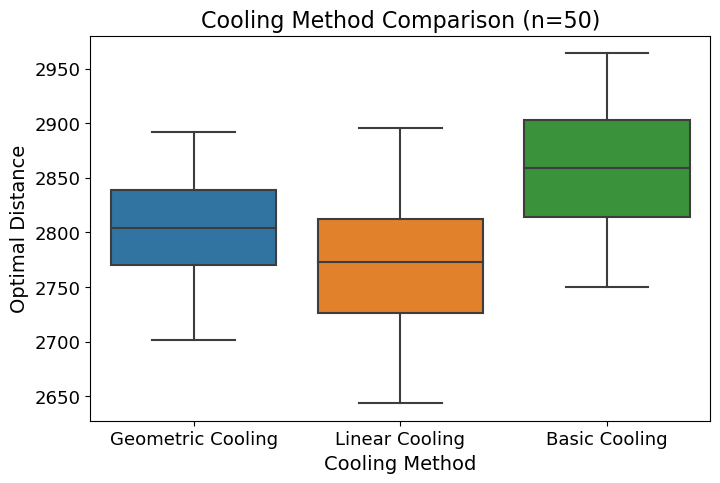

In [14]:
# Create a boxplot to compare the cooling methods: cooling method on x axis, optimal distance on y axis
n = 50

# Read the data from the csv file, columns distance_iter and temper_iter are lists of tuples
df = pd.read_csv('data/cooling_method_comparison_df_n=50.csv')

# Convert the string representation of the lists to actual lists
df['distance_iter'] = df['distance_iter'].apply(lambda x: eval(x))
df['temper_iter'] = df['temper_iter'].apply(lambda x: eval(x))

# Create a boxplot to compare the cooling methods
plt.figure(figsize=(8, 5))
sns.boxplot(x='cooling_method_name', y='optimal_distance', data=df)
plt.title(f'Cooling Method Comparison (n={n})', fontsize=16)
plt.xlabel('Cooling Method',fontsize=14)
plt.ylabel('Optimal Distance',fontsize=14)
plt.xticks([0, 1, 2], ['Geometric Cooling', 'Linear Cooling', 'Basic Cooling'], fontsize=13)
plt.yticks(fontsize=13)
plt.savefig(f'plots/3.1 cooling_method_comparison_boxplot_n={n}.png', dpi=300)
plt.show()

### Distance vs Iteration

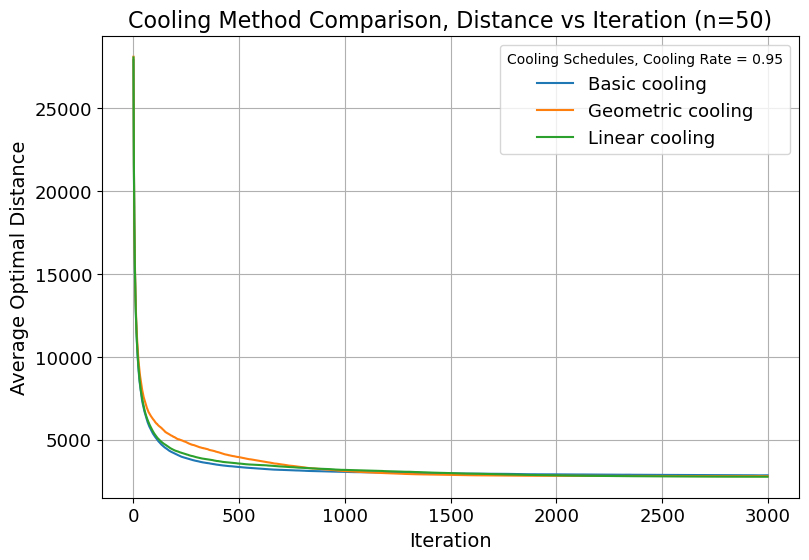

In [20]:
average_optimal_distance = df.groupby('cooling_method_name')['optimal_distance'].mean().reset_index()

# average_distance_iter = df.groupby('cooling_method_name')['distance_iter'].apply(lambda x: [tuple(map(lambda y: sum(y) / len(y), zip(*z))) for z in zip(*x)]).reset_index()
# Now distance_iter is just a list of values, not a list of tuples
average_distance_iter = df.groupby('cooling_method_name')['distance_iter'].apply(lambda x: [sum(y) / len(y) for y in zip(*x)]).reset_index()

# Merge the two DataFrames on 'cooling_method_name'
summary_df = pd.merge(average_optimal_distance, average_distance_iter, on='cooling_method_name')

# Rename columns for clarity
summary_df.columns = ['cooling_method_name', 'average_optimal_distance', 'average_distance_iter']

# Create a line plot to compare the cooling methods
plt.figure(figsize=(9, 6))
for cooling_method_name, average_distance_iter in zip(summary_df['cooling_method_name'], summary_df['average_distance_iter']):
    iters = list(range(len(average_distance_iter)))
    plt.plot(iters, average_distance_iter, label=cooling_method_name)

plt.title(f'Cooling Method Comparison, Distance vs Iteration (n={n})', fontsize=16)
plt.xlabel('Iteration', fontsize=14)
plt.ylabel('Average Optimal Distance', fontsize=14)
plt.legend(title='Cooling Schedules, Cooling Rate = 0.95', fontsize=13)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.grid(True)
plt.savefig(f'plots/3.2 cooling_method_comparison_lineplot_n={n}.png', dpi=300)
plt.show()

### Distance vs Temperature

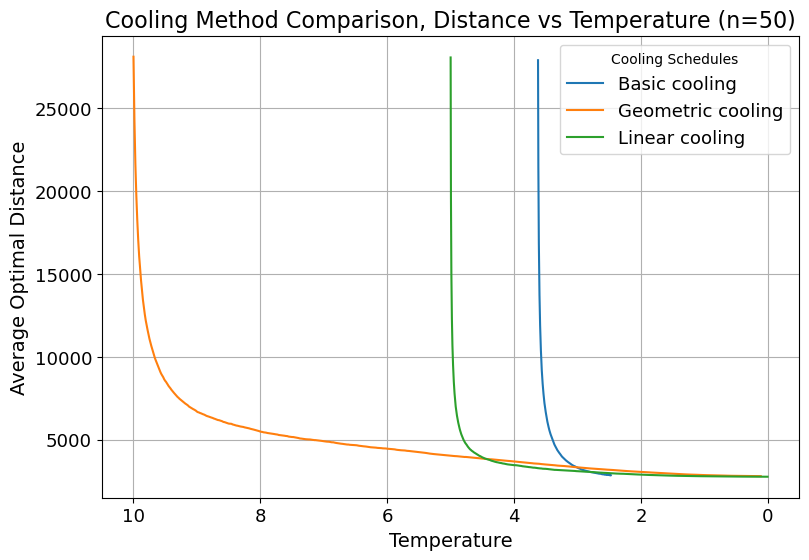

In [23]:
# Distance vs temperature
plt.figure(figsize=(9, 6))
for cooling_method_name, average_distance_iter in zip(summary_df['cooling_method_name'], summary_df['average_distance_iter']):
    iters = list(range(len(average_distance_iter)))
    temp_iters = df[df['cooling_method_name'] == cooling_method_name]['temper_iter'].iloc[0]
    plt.plot(temp_iters, average_distance_iter, label=cooling_method_name)

plt.title(f'Cooling Method Comparison, Distance vs Temperature (n={n})', fontsize=16)
plt.xlabel('Temperature', fontsize=14)
# reverse x axis
plt.gca().invert_xaxis()
plt.ylabel('Average Optimal Distance', fontsize=14)
plt.legend(title='Cooling Schedules', fontsize=13)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.grid(True)
plt.savefig(f'plots/3.3 cooling_method_comparison_lineplot_temp_n={n}.png', dpi=300)
plt.show()

### Temperature vs Iteration

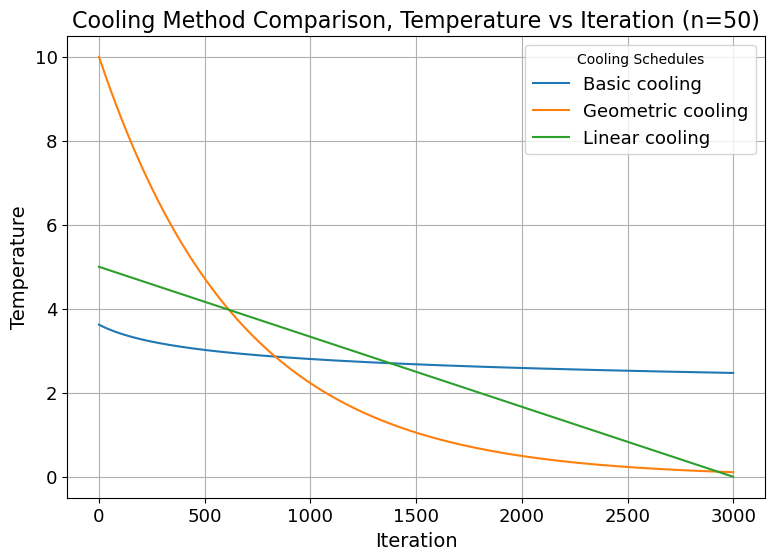

In [25]:
# Graph to plot the temperature against the iteration
# Since non-stochastic, can just look at first run of each cooling method
plt.figure(figsize=(9, 6))

# Iterate over the result DataFrame
for index, row in df.groupby('cooling_method_name')['temper_iter'].first().reset_index().iterrows():
    cooling_method_name = row['cooling_method_name']
    first_temper_iter = row['temper_iter']
    # print(f"Cooling Method: {cooling_method_name}, First Temper Iter: {first_temper_iter}")
    iters = list(range(len(first_temper_iter)))
    plt.plot(iters, first_temper_iter, label=cooling_method_name)

plt.title(f'Cooling Method Comparison, Temperature vs Iteration (n={n})', fontsize=16)
plt.xlabel('Iteration', fontsize=14)
plt.ylabel('Temperature', fontsize=14)
plt.legend(title='Cooling Schedules', fontsize=13)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.grid(True)
plt.savefig(f'plots/3.4 cooling_method_comparison_lineplot_temp_iter_n={n}.png', dpi=300)
plt.show()

## How does Markov Chain Length influence the result?

In [58]:
# Parameters for the cooling methods
max_iter = 3000
markov_chain_lengths = [10,50,100,200,400]

# Number of repetitions for each cooling method
n = 50

params_geometric_cooling = {"cooling_method_name" : "Geometric cooling",
                                "initial_temp" : 10, 
                                "max_iter": max_iter,
                                "markov_chain_length":markov_chain_length, 
                                "cooling_rate": 0.9985}

params_linear_cooling = {"cooling_method_name" : "Linear cooling",
                                "initial_temp" : 5, 
                                "max_iter": max_iter,
                                "markov_chain_length":markov_chain_length, 
                                "cooling_rate": None}

# params_logarithmic_cooling = {"cooling_method_name" : "Logarithmic cooling",
#                                 "initial_temp" : initial_temp, 
#                                 "max_iter": max_iter,
#                                 "markov_chain_length":markov_chain_length, 
#                                 "cooling_rate": cooling_rate}

params_basic_cooling = {"cooling_method_name" : "Basic cooling",
                            "initial_temp" : None, 
                            "max_iter": max_iter,
                            "markov_chain_length":markov_chain_length, 
                            "a" : 20, 
                            "b" : 250}

params_basic_cooling['initial_temp'] = params_basic_cooling['a'] / np.log(params_basic_cooling['b'])

cooling_methods = [Geometric_cooling, Linear_cooling, Basic_cooling]
optimal_parameters = [params_geometric_cooling, params_linear_cooling, params_basic_cooling]

In [60]:
# Compare the cooling methods using the optimal parameters, n times and store the results
# optimal_route, optimal_distance, distance_iter, temper_iter
import tqdm

results_markov = []
optimal_routes = []

for cooling_method, parameters in zip(cooling_methods, optimal_parameters):
    for markov_chain_length in markov_chain_lengths:
        parameters['markov_chain_length'] = markov_chain_length
        for i in tqdm.tqdm(range(n), desc=f'Running {parameters["cooling_method_name"]}'):
            optimal_route, optimal_distance, distance_iter, temper_iter = simulated_annealing(cities, two_opt_swap, cooling_method, parameters)
            distance_iter = [x[1] for x in distance_iter]
            temper_iter = [x[1] for x in temper_iter]
            optimal_routes.append(optimal_route)
            results_markov.append({'markov_chain_length':markov_chain_length, 'cooling_method_name': parameters["cooling_method_name"], 'optimal_route': optimal_route, 'optimal_distance': optimal_distance, 'distance_iter': distance_iter, 'temper_iter': temper_iter})
            
df_markov = pd.DataFrame(results_markov)
df_markov.to_csv(f'data/markov_chain_length_influence={n}.csv', index=False)

Running Basic cooling: 100%|██████████| 50/50 [23:25<00:00, 28.10s/it]


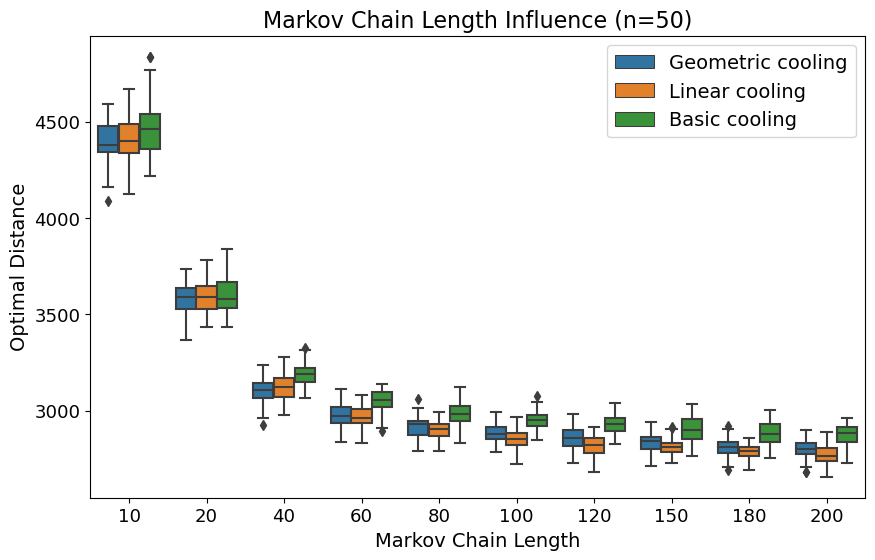

In [79]:
plt.figure(figsize=(10, 6))
df_markov = pd.read_csv('data/markov_chain_length_influence=50.csv')

sns.boxplot(x='markov_chain_length', y='optimal_distance', hue='cooling_method_name', data=df_markov)
plt.title(f'Markov Chain Length Influence (n={n})', fontsize=16)
plt.xlabel('Markov Chain Length', fontsize=14)
plt.ylabel('Optimal Distance', fontsize=14)
plt.legend(fontsize=14)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.savefig(f'plots/4.1 markov_chain_length_influence_boxplot_n={n}.png', dpi=300)
plt.show()


/var/folders/st/hfszkgw55n73h3v2jz7n8xth0000gn/T/ipykernel_20644/23856532.py:3: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  sns.lineplot(x='markov_chain_length', y='optimal_distance', hue='cooling_method_name', ci='sd', data=df_markov)


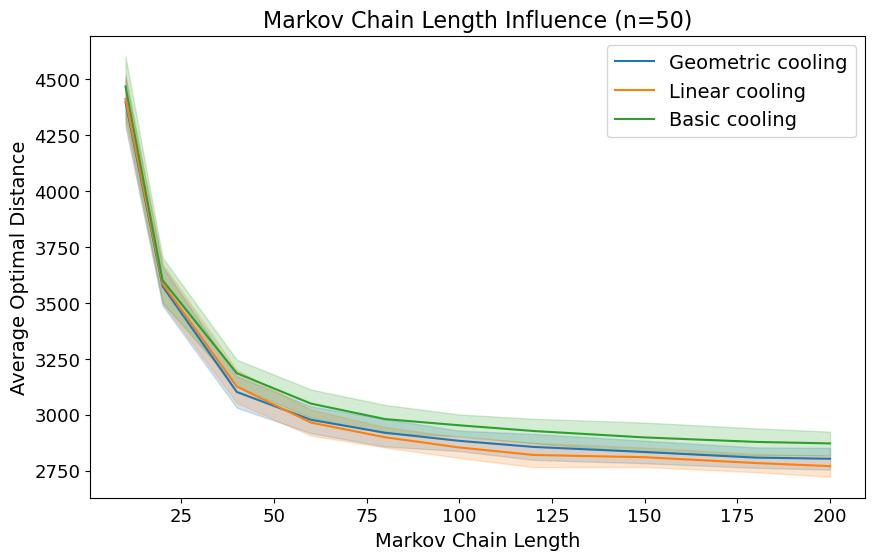

In [84]:
# Plot the average optimal distance and the standard deviation for changing markov chain length and each cooling method
plt.figure(figsize=(10, 6))
sns.lineplot(x='markov_chain_length', y='optimal_distance', hue='cooling_method_name', ci='sd', data=df_markov)
plt.title(f'Markov Chain Length Influence (n={n})', fontsize=16)
plt.xlabel('Markov Chain Length', fontsize=14)
plt.ylabel('Average Optimal Distance', fontsize=14)
plt.legend(fontsize=14)
plt.xticks(fontsize=13) 
plt.yticks(fontsize=13)
plt.savefig(f'plots/4.2 markov_chain_length_influence_lineplot_n={n}.png', dpi=300)
plt.show()




## Same 'optimal' configuration on big dataset

In [ ]:
# First, read the uploaded file pcb442.tsp.txt
file_path = 'plots/pcb442.tsp.txt'

# Define a function to read TSP files and parse city coordinates
def read_tsp_file(file_path):
    cities = []
    with open(file_path, 'r') as file:
        for line in file:
            parts = line.split()
            if len(parts) == 3 and parts[0].isdigit():
                cities.append((float(parts[1]), float(parts[2])))
    return cities

# Call the function and read the city coordinates
big_problem = read_tsp_file(file_path)

In [ ]:
n = 50

results = []
optimal_routes = []

for cooling_method, parameters in zip(cooling_methods, optimal_parameters):
    for i in tqdm.tqdm(range(n), desc=f'Running {parameters["cooling_method_name"]}'):
        optimal_route, optimal_distance, distance_iter, temper_iter = simulated_annealing(big_problem, two_opt_swap, cooling_method, parameters)
        distance_iter = [x[1] for x in distance_iter]
        temper_iter = [x[1] for x in temper_iter]
        optimal_routes.append(optimal_route)
        results.append({'cooling_method_name': parameters["cooling_method_name"], 'optimal_route': optimal_route, 'optimal_distance': optimal_distance, 'distance_iter': distance_iter, 'temper_iter': temper_iter})

df = pd.DataFrame(results)
df.to_csv(f'data/big_problem_df_n={n}.csv', index=False)

Running Basic cooling: 100%|██████████| 50/50 [1:21:38<00:00, 97.96s/it] 


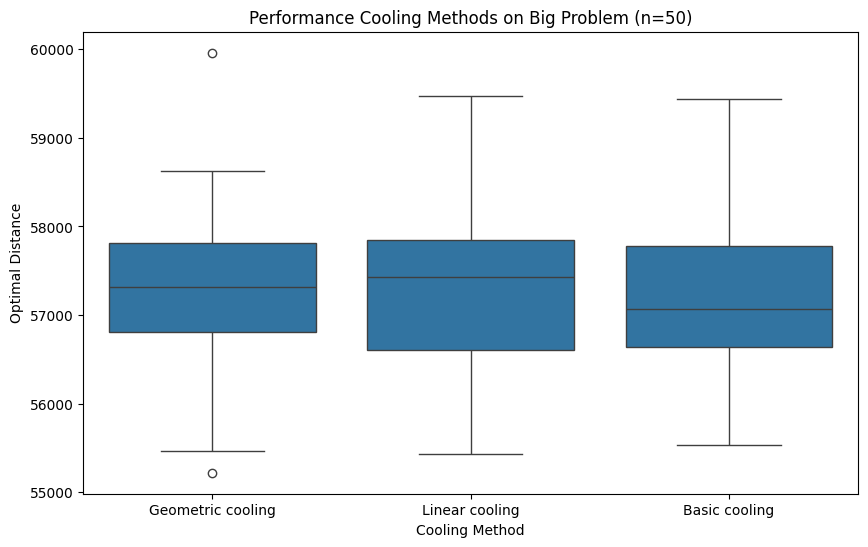

In [ ]:
# Read the data from the csv file, columns distance_iter and temper_iter are lists of tuples
df = pd.read_csv('data/big_problem_df_n=50.csv')

# Convert the string representation of the lists to actual lists
df['distance_iter'] = df['distance_iter'].apply(lambda x: eval(x))
df['temper_iter'] = df['temper_iter'].apply(lambda x: eval(x))

# Create a boxplot to compare the cooling methods
plt.figure(figsize=(10, 6))
sns.boxplot(x='cooling_method_name', y='optimal_distance', data=df)
plt.title(f'Performance Cooling Methods on Big Problem (n={n})')
plt.xlabel('Cooling Method')
plt.ylabel('Optimal Distance')
plt.show()

In [ ]:
summarising_stats = []

for cooling_method_name in df['cooling_method_name'].unique():
    runs = df[df['cooling_method_name'] == cooling_method_name]['distance_iter']
    stack = np.vstack(runs)

    means = stack.mean(axis=0)
    var = stack.var(axis=0, ddof=1)
    optimals = means[-1]

    summarising_stats.append({'cooling_method_name': cooling_method_name, 'optimal_distance': optimals, 'mean_distance_iter': means, 'var_distance_iter': var})

summary_df = pd.DataFrame(summarising_stats, columns=['cooling_method_name', 'optimal_distance', 'mean_distance_iter', 'var_distance_iter'])  

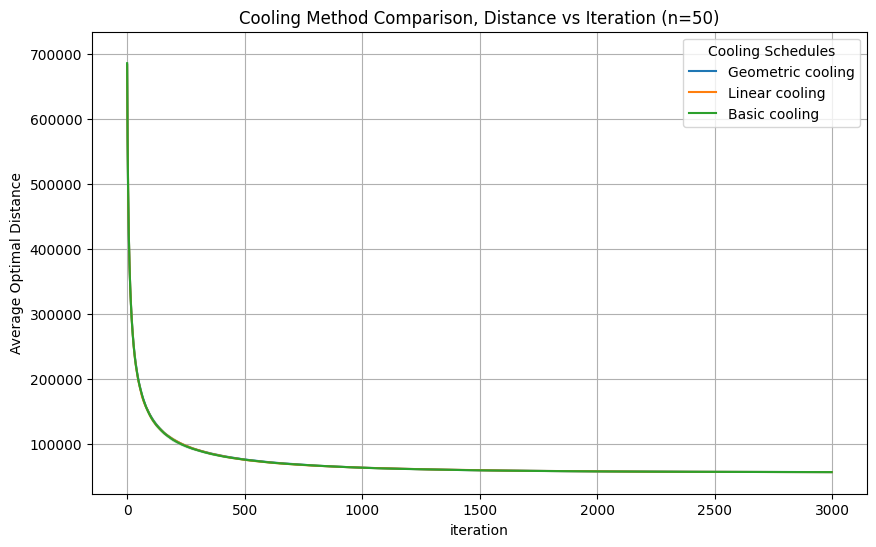

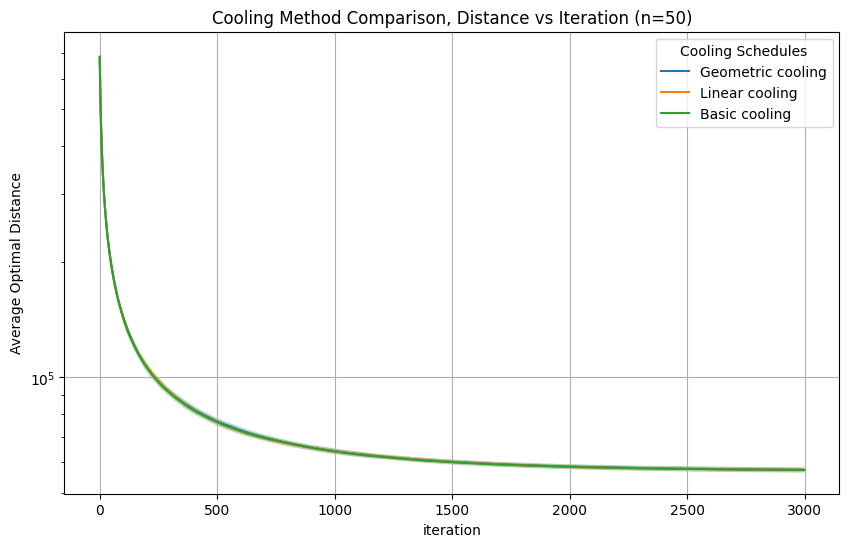

In [ ]:
# Plot distance over time with std
plt.figure(figsize=(10, 6))
for cooling_method_name, mean_distance_iter, var_distance_iter in zip(summary_df['cooling_method_name'], summary_df['mean_distance_iter'], summary_df['var_distance_iter']):
    iters = list(range(len(mean_distance_iter)))
    plt.plot(iters, mean_distance_iter, label=cooling_method_name)
    plt.fill_between(iters, mean_distance_iter - np.sqrt(var_distance_iter), mean_distance_iter + np.sqrt(var_distance_iter), alpha=0.2)

plt.title(f'Cooling Method Comparison, Distance vs Iteration (n={n})')
plt.xlabel('iteration')
plt.ylabel('Average Optimal Distance')
plt.legend(title='Cooling Schedules')
plt.grid(True)
plt.show()

# Plot again but with variance and log y axis
plt.figure(figsize=(10, 6))
for cooling_method_name, mean_distance_iter, var_distance_iter in zip(summary_df['cooling_method_name'], summary_df['mean_distance_iter'], summary_df['var_distance_iter']):
    iters = list(range(len(mean_distance_iter)))
    plt.plot(iters, mean_distance_iter, label=cooling_method_name)
    plt.fill_between(iters, mean_distance_iter - np.sqrt(var_distance_iter), mean_distance_iter + np.sqrt(var_distance_iter), alpha=0.2)

plt.title(f'Cooling Method Comparison, Distance vs Iteration (n={n})')
plt.xlabel('iteration')
plt.ylabel('Average Optimal Distance')
plt.legend(title='Cooling Schedules')
plt.grid(True)
plt.yscale('log')
plt.show()

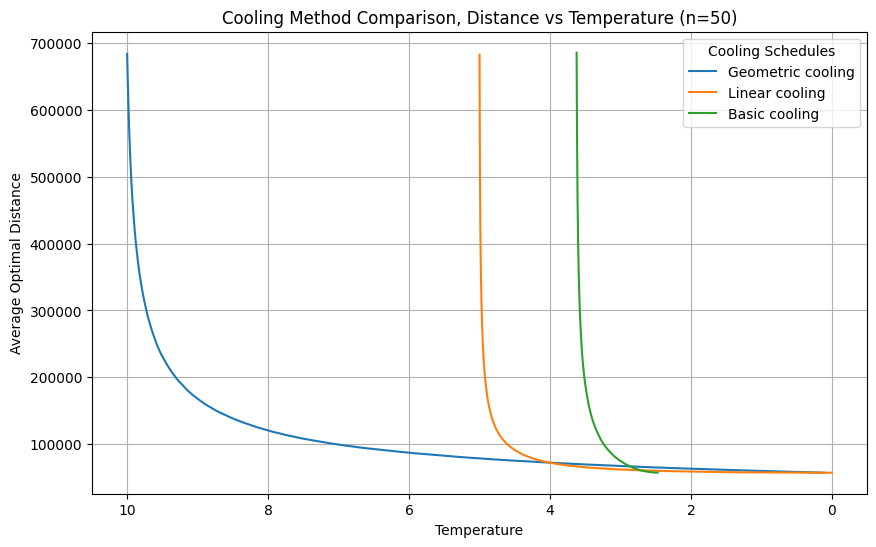

In [ ]:
# Distance vs temperature
plt.figure(figsize=(10, 6))
for cooling_method_name, mean_distance_iter in zip(summary_df['cooling_method_name'], summary_df['mean_distance_iter']):
    iters = list(range(len(mean_distance_iter)))
    temp_iters = df[df['cooling_method_name'] == cooling_method_name]['temper_iter'].iloc[0]
    plt.plot(temp_iters, mean_distance_iter, label=cooling_method_name)

plt.title(f'Cooling Method Comparison, Distance vs Temperature (n={n})')
plt.xlabel('Temperature')
# reverse x axis
plt.gca().invert_xaxis()
plt.ylabel('Average Optimal Distance')
plt.legend(title='Cooling Schedules')
plt.grid(True)
plt.show()

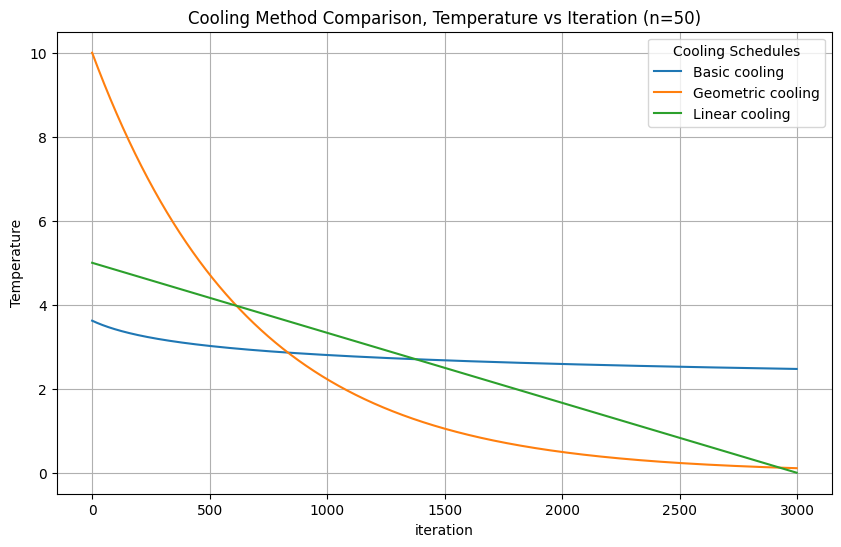

In [ ]:
# Graph to plot the temperature against the iteration
# Since non-stochastic, can just look at first run of each cooling method
plt.figure(figsize=(10, 6))

# Iterate over the result DataFrame
for index, row in df.groupby('cooling_method_name')['temper_iter'].first().reset_index().iterrows():
    cooling_method_name = row['cooling_method_name']
    first_temper_iter = row['temper_iter']
    # print(f"Cooling Method: {cooling_method_name}, First Temper Iter: {first_temper_iter}")
    iters = list(range(len(first_temper_iter)))
    plt.plot(iters, first_temper_iter, label=cooling_method_name)

plt.title(f'Cooling Method Comparison, Temperature vs Iteration (n={n})')
plt.xlabel('iteration')
plt.ylabel('Temperature')
plt.legend(title='Cooling Schedules')
plt.grid(True)
plt.show()

In [ ]:
# Read optimal routes from csv
a280_opt_route = []
with open('plots/a280.opt.tour.txt', 'r') as file:
    for line in file:
        if line.split()[0].isdigit() and int(line.split()[0]) == -1:
            break
        
        if line.split()[0].isdigit() and len(line.split()) == 1:
            a280_opt_route.append(int(line) - 1)

pcb442_opt_route = []
with open('plots/pcb442.opt.tour.txt', 'r') as file:
    for line in file:
        if line.split()[0].isdigit() and int(line.split()[0]) == -1:
            break
        
        if line.split()[0].isdigit() and len(line.split()) == 1:
            pcb442_opt_route.append(int(line) - 1)

# Find lengths:
a280_opt_distance = calculate_total_distance(cities, a280_opt_route)
pcb442_opt_distance = calculate_total_distance(big_problem, pcb442_opt_route)

print(f"Optimal route length for a280: {a280_opt_distance}")
print(f"Optimal route length for pcb442: {pcb442_opt_distance}")

Optimal route length for a280: 2586.7696475631606
Optimal route length for pcb442: 50783.54751373533


## Use a combined cooling function to optimize algorithms better  

### Combined cooling function

In [ ]:
def Combined_cooling(current_temp, iter, parameters):
    if parameters["current_stage"] == 1:
        return parameters["initial_temp"] / (1 + np.log(1 + iter)) + 1
    elif parameters["current_stage"] == 2:
        return max(current_temp - parameters["linear_cooling_rate1"],parameters["temper_threshold1"])
    elif parameters["current_stage"] == 3:
        return max(current_temp - parameters["linear_cooling_rate2"],parameters["temper_threshold2"])

In [ ]:
def stage(parameters, current_distance):
    if current_distance > 30000:
        current_stage = 1
        parameters["stop_stage1"] = parameters['total_runs'] - parameters['left_runs']
    elif current_distance > 2800 and parameters['left_runs'] > parameters['run_threshold1']:
        current_stage = 2
        parameters["stop_stage2"] = parameters['total_runs'] - parameters['left_runs']
    else:
        current_stage = 3
    return current_stage

In [ ]:
def adjust_markov_chain_length(current_stage):
    if current_stage == 1:
        return parameters['markov_chain_stage1']
    if current_stage == 2:
        return parameters['markov_chain_stage2']
    if current_stage == 3:
        return parameters['markov_chain_stage3']

### Update simulated_annealing function

In [ ]:
def simulated_annealing_Combined_cooling(cities, Optimize_function, Cooling_fuction, parameters):
    """Simulated annealing algorithm main function with dynamic Markov Chain length."""

    # Randomly initialize a solution (route)
    current_route = list(range(len(cities)))
    random.shuffle(current_route)

    current_distance = calculate_total_distance(cities, current_route)

    temper = Temperature(Cooling_fuction, parameters)
    distance_run = []
    temper_run = []

    #Record the previous function value
    while parameters["left_runs"] > 0:
        # Adjust Markov Chain length based on current performance
        parameters["current_stage"] = stage(parameters, current_distance)
        markov_chain_length = adjust_markov_chain_length(parameters["current_stage"])
        
        #print(current_distance)
        #print(f"total_runs:{parameters['left_runs']}")
        #print(f"temper:{temper.current_temp}")
        
        for _ in range(markov_chain_length):
            # Generate new solution
            new_route = Optimize_function(current_route)
            new_distance = calculate_total_distance(cities, new_route)

            # Determine whether to accept the new solution
            if new_distance < current_distance or random.random() < math.exp((current_distance - 
                                                            new_distance) / temper.current_temp):

                current_route = new_route
                current_distance = new_distance
        parameters["left_runs"] -= markov_chain_length
        
        distance_run.append((parameters["total_runs"] - parameters["left_runs"] , current_distance))     
        temper_run.append((parameters["total_runs"] - parameters["left_runs"] , temper.current_temp))    
        temper.update_temperature()
        
    return current_route, current_distance, distance_run, temper_run

### Visualization

In [ ]:
def cooling_function_compare(cooling_method_names, parameter_iters, parameter_name):
    """
    Function to compare different cooling methods for simulated annealing.
    
    Parameters:
    cooling_method_names (list): A list of names of the cooling methods.
    distance_iters (list): A list of tuples/lists containing iteration-distance pairs for each cooling method.
    """
    plt.figure(figsize=(10, 6))
    
    # Iterate over the provided cooling methods and distance-iteration data
    for method_name, dist_iter in zip(cooling_method_names, parameter_iters):
        # Unpack the iteration and distance data
        iters, distances = zip(*dist_iter)
        
        # Plot the data with a label for the legend
        plt.plot(iters, distances, label=method_name)
    
    # Add title and labels
    plt.title('Cooling Function character', fontsize=16)
    plt.xlabel('K (Runs)', fontsize=14)
    plt.ylabel(f'{parameter_name}', fontsize=14)
    plt.legend(title='Cooling Schedules', fontsize=12)
    plt.grid(True)
    
    # Display the plot
    plt.show()

def cooling_temper(cooling_method_names, parameter_iters, parameter_name, run_threshold0, run_threshold1):
    """
    Function to compare different cooling methods for simulated annealing.
    
    Parameters:
    cooling_method_names (list): A list of names of the cooling methods.
    distance_iters (list): A list of tuples/lists containing iteration-distance pairs for each cooling method.
    """
    
    plt.figure(figsize=(10, 6))
    
    # Iterate over the provided cooling methods and distance-iteration data
    for method_name, dist_iter in zip(cooling_method_names, parameter_iters):
        # Unpack the iteration and distance data
        iters, distances = zip(*dist_iter)
        method_name = "Combined cooling"
        # Plot the data with a label for the legend
        plt.plot(iters, distances, label=method_name)
    
    # Add gray dotted line
    plt.axvline(x=run_threshold0, color='grey', linestyle='--')
    plt.axvline(x=run_threshold1, color='grey', linestyle='--')

    # Labeling stage
    plt.text(run_threshold0 / 2, plt.ylim()[1] * 0.9, 'Stage 1', horizontalalignment='center')
    plt.text((run_threshold0 + run_threshold1) / 2, plt.ylim()[1] * 0.9, 'Stage 2', horizontalalignment='center')
    plt.text((run_threshold1 + plt.xlim()[1]) / 2, plt.ylim()[1] * 0.9, 'Stage 3', horizontalalignment='center')

    # Add title and labels
    plt.title('Cooling Function character', fontsize=16)
    plt.xlabel('K (Runs)', fontsize=14)
    plt.ylabel(f'{parameter_name}', fontsize=14)
    plt.legend(title='Cooling Schedules', fontsize=12, loc='lower right', bbox_to_anchor=(1, 1))


    plt.grid(True)
    
    # Display the plot
    plt.show()

### Combined cooling test

In [ ]:
initial_temp = 10
otherfuntion_max_iter = 10000 * 3
otherfuntion_markov_chain_length = 20
total_runs = otherfuntion_max_iter * otherfuntion_markov_chain_length
markov_chain_stage1 = 10
markov_chain_stage2 = 10
markov_chain_stage3 = 10
beta = 0.3
run_threshold1 = beta * total_runs

temper_threshold1 = 1.5
temper_threshold2 = 0.1

alpha1 = 0.2
alpha2 = 10
linear_cooling_rate1 = (initial_temp - temper_threshold1) / (total_runs * (1 - run_threshold1 / total_runs - 0.1) /
                                                markov_chain_stage2 ) * alpha1
linear_cooling_rate2 = (temper_threshold1- temper_threshold2) / (total_runs * (0.3) / 
                                                markov_chain_stage3) * alpha2
print(linear_cooling_rate1)
print(linear_cooling_rate2)
parameters_Test2_cooling = { "cooling_method_name" : "Test2_cooling",
                            "initial_temp" : initial_temp, 
                            "total_runs": total_runs,
                            "left_runs": total_runs,
                            "markov_chain_stage1": markov_chain_stage1,
                            "markov_chain_stage2": markov_chain_stage2,
                            "markov_chain_stage3": markov_chain_stage3,
                            "stop_stage1":0,
                            "stop_stage2":0,
                            "run_threshold1":run_threshold1,
                            "temper_threshold1":temper_threshold1,
                            "temper_threshold2":temper_threshold2,
                            "linear_cooling_rate1":linear_cooling_rate1,
                            "linear_cooling_rate2":linear_cooling_rate2,
                            "current_stage":1

                            }

cooling_functions = [
(Combined_cooling,parameters_Test2_cooling)
]

optimal_routes = []
optimal_distances = []
cooling_method_names = []
distance_runs = []
temper_runs = []

for cooling_function, parameters in cooling_functions:
    optimal_route, optimal_distance, distance_run, temper_run = simulated_annealing_Combined_cooling(cities, two_opt_swap, 
                                                                            cooling_function, parameters)
    optimal_routes.append(optimal_route)
    optimal_distances.append(optimal_distance)
    cooling_method_names.append(parameters["cooling_method_name"])
    distance_runs.append(distance_run)
    temper_runs.append(temper_run)

    print("Cooling_method_name:", parameters["cooling_method_name"])
    print("Optimal Route:", optimal_route)
    print("Optimal Distance:", optimal_distance)
    print()

In [ ]:
cooling_function_compare(cooling_method_names, distance_runs, "distance")
cooling_temper(cooling_method_names, temper_runs, "Temper", parameters["stop_stage1"], parameters["stop_stage2"])
# Draw the solution using the optimal path and city coordinates found previously
for optimal_route in optimal_routes:
    plot_tsp_solution(cities, optimal_route, "Geometric_cooling")

### Run 50 times

In [ ]:
def test_main():
    initial_temp = 10
    otherfuntion_max_iter = 10000 * 3
    otherfuntion_markov_chain_length = 20
    total_runs = otherfuntion_max_iter * otherfuntion_markov_chain_length
    markov_chain_stage1 = 10
    markov_chain_stage2 = 10
    markov_chain_stage3 = 10

    beta = 0.3
    run_threshold1 = beta * total_runs

    temper_threshold1 = 1.5
    temper_threshold2 = 0.1

    alpha1 = 0.2
    alpha2 = 10
    linear_cooling_rate1 = (3 - temper_threshold1) / (total_runs * (1 - run_threshold1 / total_runs - 0.1) /
                                                    markov_chain_stage2 ) * alpha1
    linear_cooling_rate2 = (temper_threshold1- temper_threshold2) / (total_runs * (0.3) / 
                                                    markov_chain_stage3) * alpha2
    print(linear_cooling_rate1)
    print(linear_cooling_rate2)
    parameters_Test2_cooling = {    "cooling_method_name" : "Test2_cooling",
                                "initial_temp" : initial_temp, 
                                "total_runs": total_runs,
                                "left_runs": total_runs,
                                "markov_chain_stage1": markov_chain_stage1,
                                "markov_chain_stage2": markov_chain_stage2,
                                "markov_chain_stage3": markov_chain_stage3,
                                "stop_stage1":0,
                                "stop_stage2":0,
                                "run_threshold1":run_threshold1,
                                "temper_threshold1":temper_threshold1,
                                "temper_threshold2":temper_threshold2,
                                "linear_cooling_rate1":linear_cooling_rate1,
                                "linear_cooling_rate2":linear_cooling_rate2,
                                "current_stage":1

                                }

    cooling_functions = [
    (Combined_cooling,parameters_Test2_cooling)
    ]

    optimal_routes = []
    optimal_distances = []
    cooling_method_names = []
    distance_runs = []
    temper_runs = []

    for cooling_function, parameters in cooling_functions:
        optimal_route, optimal_distance, distance_run, temper_run = simulated_annealing_Combined_cooling(cities, two_opt_swap, 
                                                                                cooling_function, parameters)
        optimal_routes.append(optimal_route)
        optimal_distances.append(optimal_distance)
        cooling_method_names.append(parameters["cooling_method_name"])
        distance_runs.append(distance_run)
        temper_runs.append(temper_run)

        print("Cooling_method_name:", parameters["cooling_method_name"])
        #print("Optimal Route:", optimal_route)
        print("Optimal Distance:", optimal_distance)
        print()
    return optimal_distance

In [ ]:
optimal_distancess = []
for i in range(50):
    optimal_distancess.append(test_main())

In [ ]:
print(optimal_distancess)

print(np.mean(optimal_distancess))
print(np.var(optimal_distancess))

### Draw boxplot

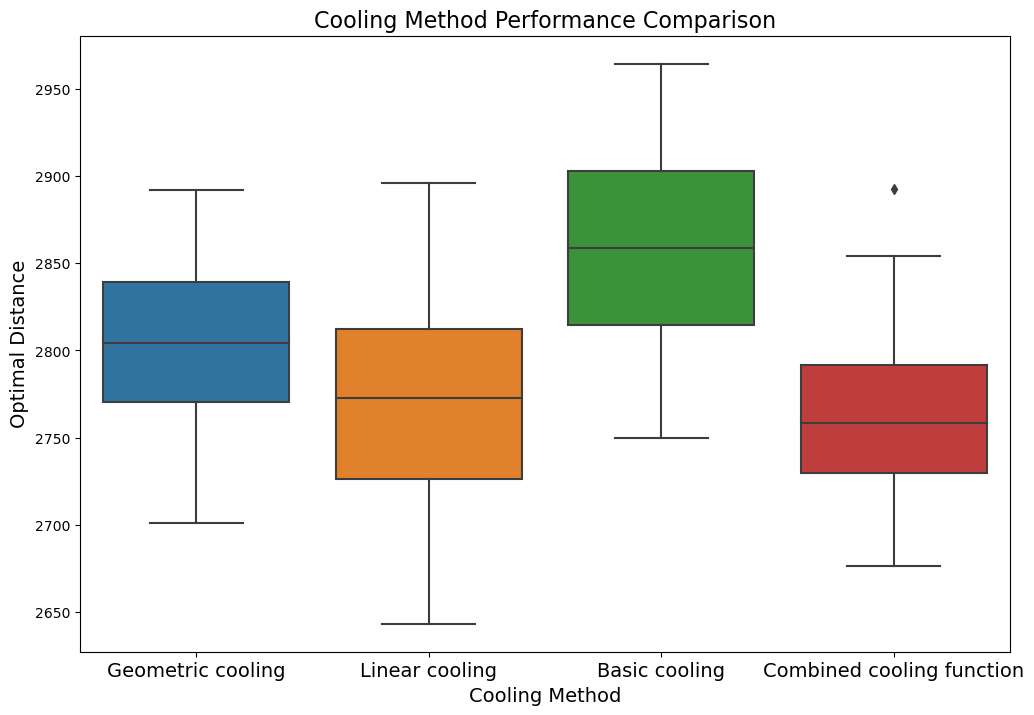

In [28]:
df1 = pd.read_csv('data/cooling_method_comparison_df_n=50.csv')
df1['distance_iter'] = df1['distance_iter'].apply(lambda x: eval(x))
df1['temper_iter'] = df1['temper_iter'].apply(lambda x: eval(x))

# Assume optimal_distancess is a list or sequence you have defined
df2 = pd.DataFrame({'cooling_method_name': ['Combined cooling function'] * len(optimal_distancess),
                    'optimal_distance': optimal_distancess})

# Merge two data sets
combined_df = pd.concat([df1, df2])

# Draw the merged box plot
plt.figure(figsize=(12, 8))
sns.boxplot(x='cooling_method_name', y='optimal_distance', data=combined_df)
plt.title('Cooling Method Performance Comparison', fontsize=16)
plt.xlabel('Cooling Method', fontsize=14)
plt.ylabel('Optimal Distance', fontsize=14)
plt.xticks(fontsize=14)  
plt.show()